### Code 3 Weighting

In [8]:
import numpy as np
import pandas as pd
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmasher as cmr
import seaborn as sns
import math

from mpl_toolkits.basemap import Basemap
pd.set_option('max_columns', None)
from netCDF4 import Dataset
from pathlib import Path
from dateutil.relativedelta import *
import itertools

#### [1] Process data and save predictors results of weighted ensemble (Table4)

In [9]:
#[1] Read results of simple ensemble mean
resm= pd.read_csv('res_Table3_Subset_selection.csv', index_col=0)


#[2] Dataframe for summary reults of weighted ensemble mean
NME=['3210','321X','32XX','3XXX']
members=['obs', *[*NME]]
columns=['OF','e_size', 'KB','LCN','LCS','LCN_NB','LCN_B','LCS_NB','LCS_B','Err_KB', \
         'Match_LCN','Match_LCS','Match_Tot','Err_LCN','Err_LCS','Err_Tot','RMSE']
reswm = pd.DataFrame(columns = columns,index=members)
reswm.iloc[0,0]=1
reswm.iloc[0,1:]=resm.iloc[0,:]


#[3] Dataframe for model data (zos) of weighted ensemble mean
columns=['KB','obs', *NME]
Q=pd.date_range('1993-01-01', periods=44, freq='2Q',closed='left')
reswMD= pd.DataFrame(columns=columns,index=Q)
resMD=pd.DataFrame(columns=columns,index=Q)
m0=loadmat('zos_data_B300_opt_R3210.mat')
reswMD.KB=m0['KB'].T
reswMD.obs=m0['LCO'].T
resMD.KB=m0['KB'].T
resMD.obs=m0['LCO'].T

#[4] Dataframe for model weights (Member names, scores and weights)
resMW=pd.read_csv('res_Table2_members_score.csv',index_col=0) 
header_list=['Source_ID','e_size','Score', *NME]
resMW = resMW.reindex(columns = header_list)  
resMW[[*NME]]=0
resMW=resMW.iloc[1:].T
MMES=np.array([1,1,1,1])

#[5] Loop ensembles to load data
for n,nme in enumerate(NME):
    
    #(5.1) Load data
    file='opt_res_R{}.mat'.format(nme)
    print(file)
    m=loadmat(file)

    #(5.2) Find optimal solution 
    Info=m['SO_Info']
    fit=1  #[0] Solution with minimum RMSE, [1] Solution with minimum fitness
    if fit==0:
        ridx=np.argmin(Info[:,-1], axis=0)
    elif fit==1:    
        ridx=np.argmin(Info[:,0], axis=0)
    #print('{} : Index of optimal solution {} give {}'.format(nme,ridx,Info.shape))
    
    #(5.3) Summary results
    reswm.loc[nme,:]=Info[ridx:ridx+1,:]
    
    if nme=='3XXX':
        #Round RMSE
        reswm.RMSE=reswm.RMSE.astype(float).round(2)  

        #Shift OF column to the end
        cols = reswm.columns.tolist()
        cols = cols[1:] + [cols[0]]
        reswm=reswm[cols]
    

    #(5.4.1) Weighted Model data
    reswMD.loc[:,nme]=m['SO_MD'][ridx,:]
    
    #(5.4.2) Mode data
    file='zos_data_B300_opt_R{}.mat'.format(nme)
    print(file)
    m0=loadmat(file)
    resMD.loc[:,nme]=m0['LCM'].T
    
    #(5.5) Mode weights
    #Ensemble index given score
    #Note that the loc list is manually created to save time 
    #(but can be easily automated given member score and enemble name e.g.,'3210')
    if nme=='3210':
        loc=[*range(11)]
    elif nme=='321X':    
        loc=[0,1,2,5,6,7,8,9,10]
    elif nme=='32XX':
        loc=[1,5,6,7,8,9,10]
    elif nme=='3XXX':
        loc=[6,7,9,10]
    MMES[n]=len(loc)
    
    #Optimal model weight
    MW=m['SO_MW'][ridx,:]
    for n,mw in enumerate(MW):
        resMW.loc[nme,'Member{}'.format(loc[n])]=MW[n]
    
#[6] Display results
#Model summary predictors
display(resm)
display(reswm)

# #Model data
# display(reswMD)
# display(resMD)

#Model weights
display(resMW)
print('Multi-model ensemble size:',NME,MMES)

#[7] Save results
reswm.to_csv('res_Table4_Weighting.csv')

opt_res_R3210.mat
zos_data_B300_opt_R3210.mat
opt_res_R321X.mat
zos_data_B300_opt_R321X.mat
opt_res_R32XX.mat
zos_data_B300_opt_R32XX.mat
opt_res_R3XXX.mat
zos_data_B300_opt_R3XXX.mat


,e_size,KB,LCN,LCS,LCN_NB,LCN_B,LCS_NB,LCS_B,Err_KB,Match_LCN,Match_LCS,Match_Tot,Err_LCN,Err_LCS,Err_Tot,RMSE
obs,1,15,32,12,17,15,12,0,0.000,32,12,44,0.000,0.000,0.000,0.00
3210,41,15,3,41,2,1,27,14,0.933,2,11,13,0.938,0.083,0.705,5.13
321X,33,15,34,10,22,12,7,3,0.200,25,3,28,0.219,0.750,0.364,3.71
32XX,28,15,23,21,17,6,12,9,0.600,17,6,23,0.469,0.500,0.477,3.92
3XXX,20,15,35,9,22,13,7,2,0.133,28,5,33,0.125,0.583,0.250,3.68
XXX0,8,15,0,44,0,0,29,15,1.000,0,12,12,1.000,0.000,0.727,13.52


,e_size,KB,LCN,LCS,LCN_NB,LCN_B,LCS_NB,LCS_B,Err_KB,Match_LCN,Match_LCS,Match_Tot,Err_LCN,Err_LCS,Err_Tot,RMSE,OF
obs,1,15,32,12,17,15,12,0,0,32,12,44,0,0,0,0.00,1
3210,41,15,34,10,20,14,9,1,0.0666667,29,7,36,0.09375,0.416667,0.181818,3.56,286.484
321X,33,15,34,10,20,14,9,1,0.0666667,29,7,36,0.09375,0.416667,0.181818,3.59,289.126
32XX,28,15,34,10,20,14,9,1,0.0666667,29,7,36,0.09375,0.416667,0.181818,3.69,296.917
3XXX,20,15,34,10,20,14,9,1,0.0666667,28,6,34,0.125,0.5,0.227273,3.67,543.028


,Member0,Member1,Member2,Member3,Member4,Member5,Member6,Member7,Member8,Member9,Member10
Source_ID,CESM1-CAM5-SE-HR,CMCC-CM2-HR4,CNRM-CM6-1-HR,E3SM-1-0,EC-Earth3P,EC-Earth3P-HR,ECMWF-IFS-HR,ECMWF-IFS-MR,GFDL-CM4,HadGEM3-GC31-HH,HadGEM3-GC31-MM
e_size,1,2,4,5,3,3,6,3,3,4,7
Score,1,2,1,0,0,2,3,3,2,3,3
3210,3.32611e-11,0.029499,0.24471,0.0480413,2.80077e-10,0.142644,0.0249725,0.410147,0.0846491,0.00172186,0.0136149
321X,2.11207e-11,0.0253597,0.13818,0,0,0.140738,8.7644e-09,0.522944,0.120754,0.00942347,0.0426004
32XX,0,0.05273,0,0,0,5.99673e-11,0.0776824,0.436983,0.0832713,0.24621,0.103123
3XXX,0,0,0,0,0,0,0.271232,0.499676,0,0.0621677,0.166924


Multi-model ensemble size: ['3210', '321X', '32XX', '3XXX'] [11  9  7  4]


#### [2] Figure4 Member weight

Source_ID,"IMS01: CESM1-CAM5-SE-HR (Size 1, Score 1)","IMS02: CMCC-CM2-(V)HR4 (Size 2, Score 2)","IMS03: CNRM-CM6-1-HR (Size 4, Score 1)","IMS04: E3SM-1-0 (Size 5, Score 0)","IMS05: EC-Earth3P (Size 3, Score 0)","IMS06: EC-Earth3P-HR (Size 3, Score 2)","IMS07: ECMWF-IFS-HR (Size 6, Score 3)","IMS08: ECMWF-IFS-MR (Size 3, Score 3)","IMS09: GFDL-CM4/ESM4 (Size 3, Score 2)","IMS10: HadGEM3-GC31-HH/HM (Size 4, Score 3)","IMS11: HadGEM3-GC31-MM (Size 7, Score 3)"
WME3210 (Size 11),0.0,0.03,0.24,0.05,0.0,0.14,0.02,0.41,0.08,0.00,0.01
WME321X (Size 9),0.0,0.03,0.14,0.00,0.0,0.14,0.00,0.52,0.12,0.01,0.04
WME32XX (Size 7),0.0,0.05,0.00,0.00,0.0,0.00,0.08,0.44,0.08,0.25,0.10
WME3XXX (Size 4),0.0,0.00,0.00,0.00,0.0,0.00,0.27,0.50,0.00,0.06,0.17


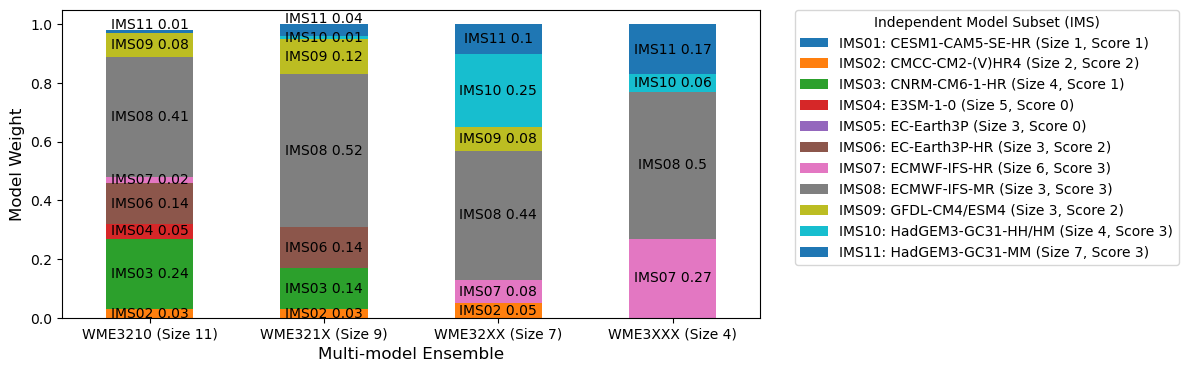

In [10]:
#Create new header and extract model weights 
header = resMW.iloc[0].copy() #grab the first row for the header
header.iloc[1]='CMCC-CM2-(V)HR4'
header.iloc[8]='GFDL-CM4/ESM4'
header.iloc[9]='HadGEM3-GC31-HH/HM'

#IMS size
Size=resMW.iloc[1].copy()

#IMS score
Score=resMW.iloc[2].copy()

#Create header for new df
for n in range(header.shape[0]):
    header.iloc[n]='IMS{:02d}: {} (Size {}, Score {})'.format(n+1,header[n],Size[n],Score[n])
MW = resMW[3:].copy() 
MW.columns = header

#round model weights
MW=MW.astype(float).round(2)

#Add multi-model ensembe size to index column
New_Indix = ['WME{} (Size {})'.format(MW.index.tolist()[n],es) for n,es in enumerate(MMES)]
MW.set_axis(New_Indix, inplace=True)

#Display data
display(MW)

#Select plot style
plt.style.use('default')
#plt.style.use('seaborn-colorblind')

#Plot df
ax = MW.plot(stacked=True, kind='bar', figsize=(9, 4), rot='horizontal')


# Annotate the plot (.patches is everything inside of the chart)
for n,rect in enumerate(ax.patches):
    
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    
    #Text
    # Value: The height of the bar is the data value and can be used as the label
    label_text = f'{np.round(height,2)}'  # f'{height:.2f}' to format decimal values
    
    #IMS number
    IMS=math.ceil((n+1)/4)
    label_text='IMS{:02d} {}'.format(IMS,label_text)
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    
   
    # plot only when height is greater than specified value
    #print(n,rect,label_text)
    if height > 0:
        if (n==40 or n==40):
            ax.text(label_x, label_y, label_text, ha='center', va='bottom', fontsize=10)
        elif n==41:
            ax.text(label_x, label_y+0.014, label_text, ha='center', va='bottom', fontsize=10)
        else:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Independent Model Subset (IMS)', borderaxespad=0.)    
ax.set_ylabel("Model Weight", fontsize=12)
ax.set_xlabel("Multi-model Ensemble", fontsize=12)
plt.savefig('res_Fig04_Model_Weight{}.tif'.format(fit),bbox_inches='tight')
plt.show()

#### [3] Figure5 delta zos per period (Data,Model)

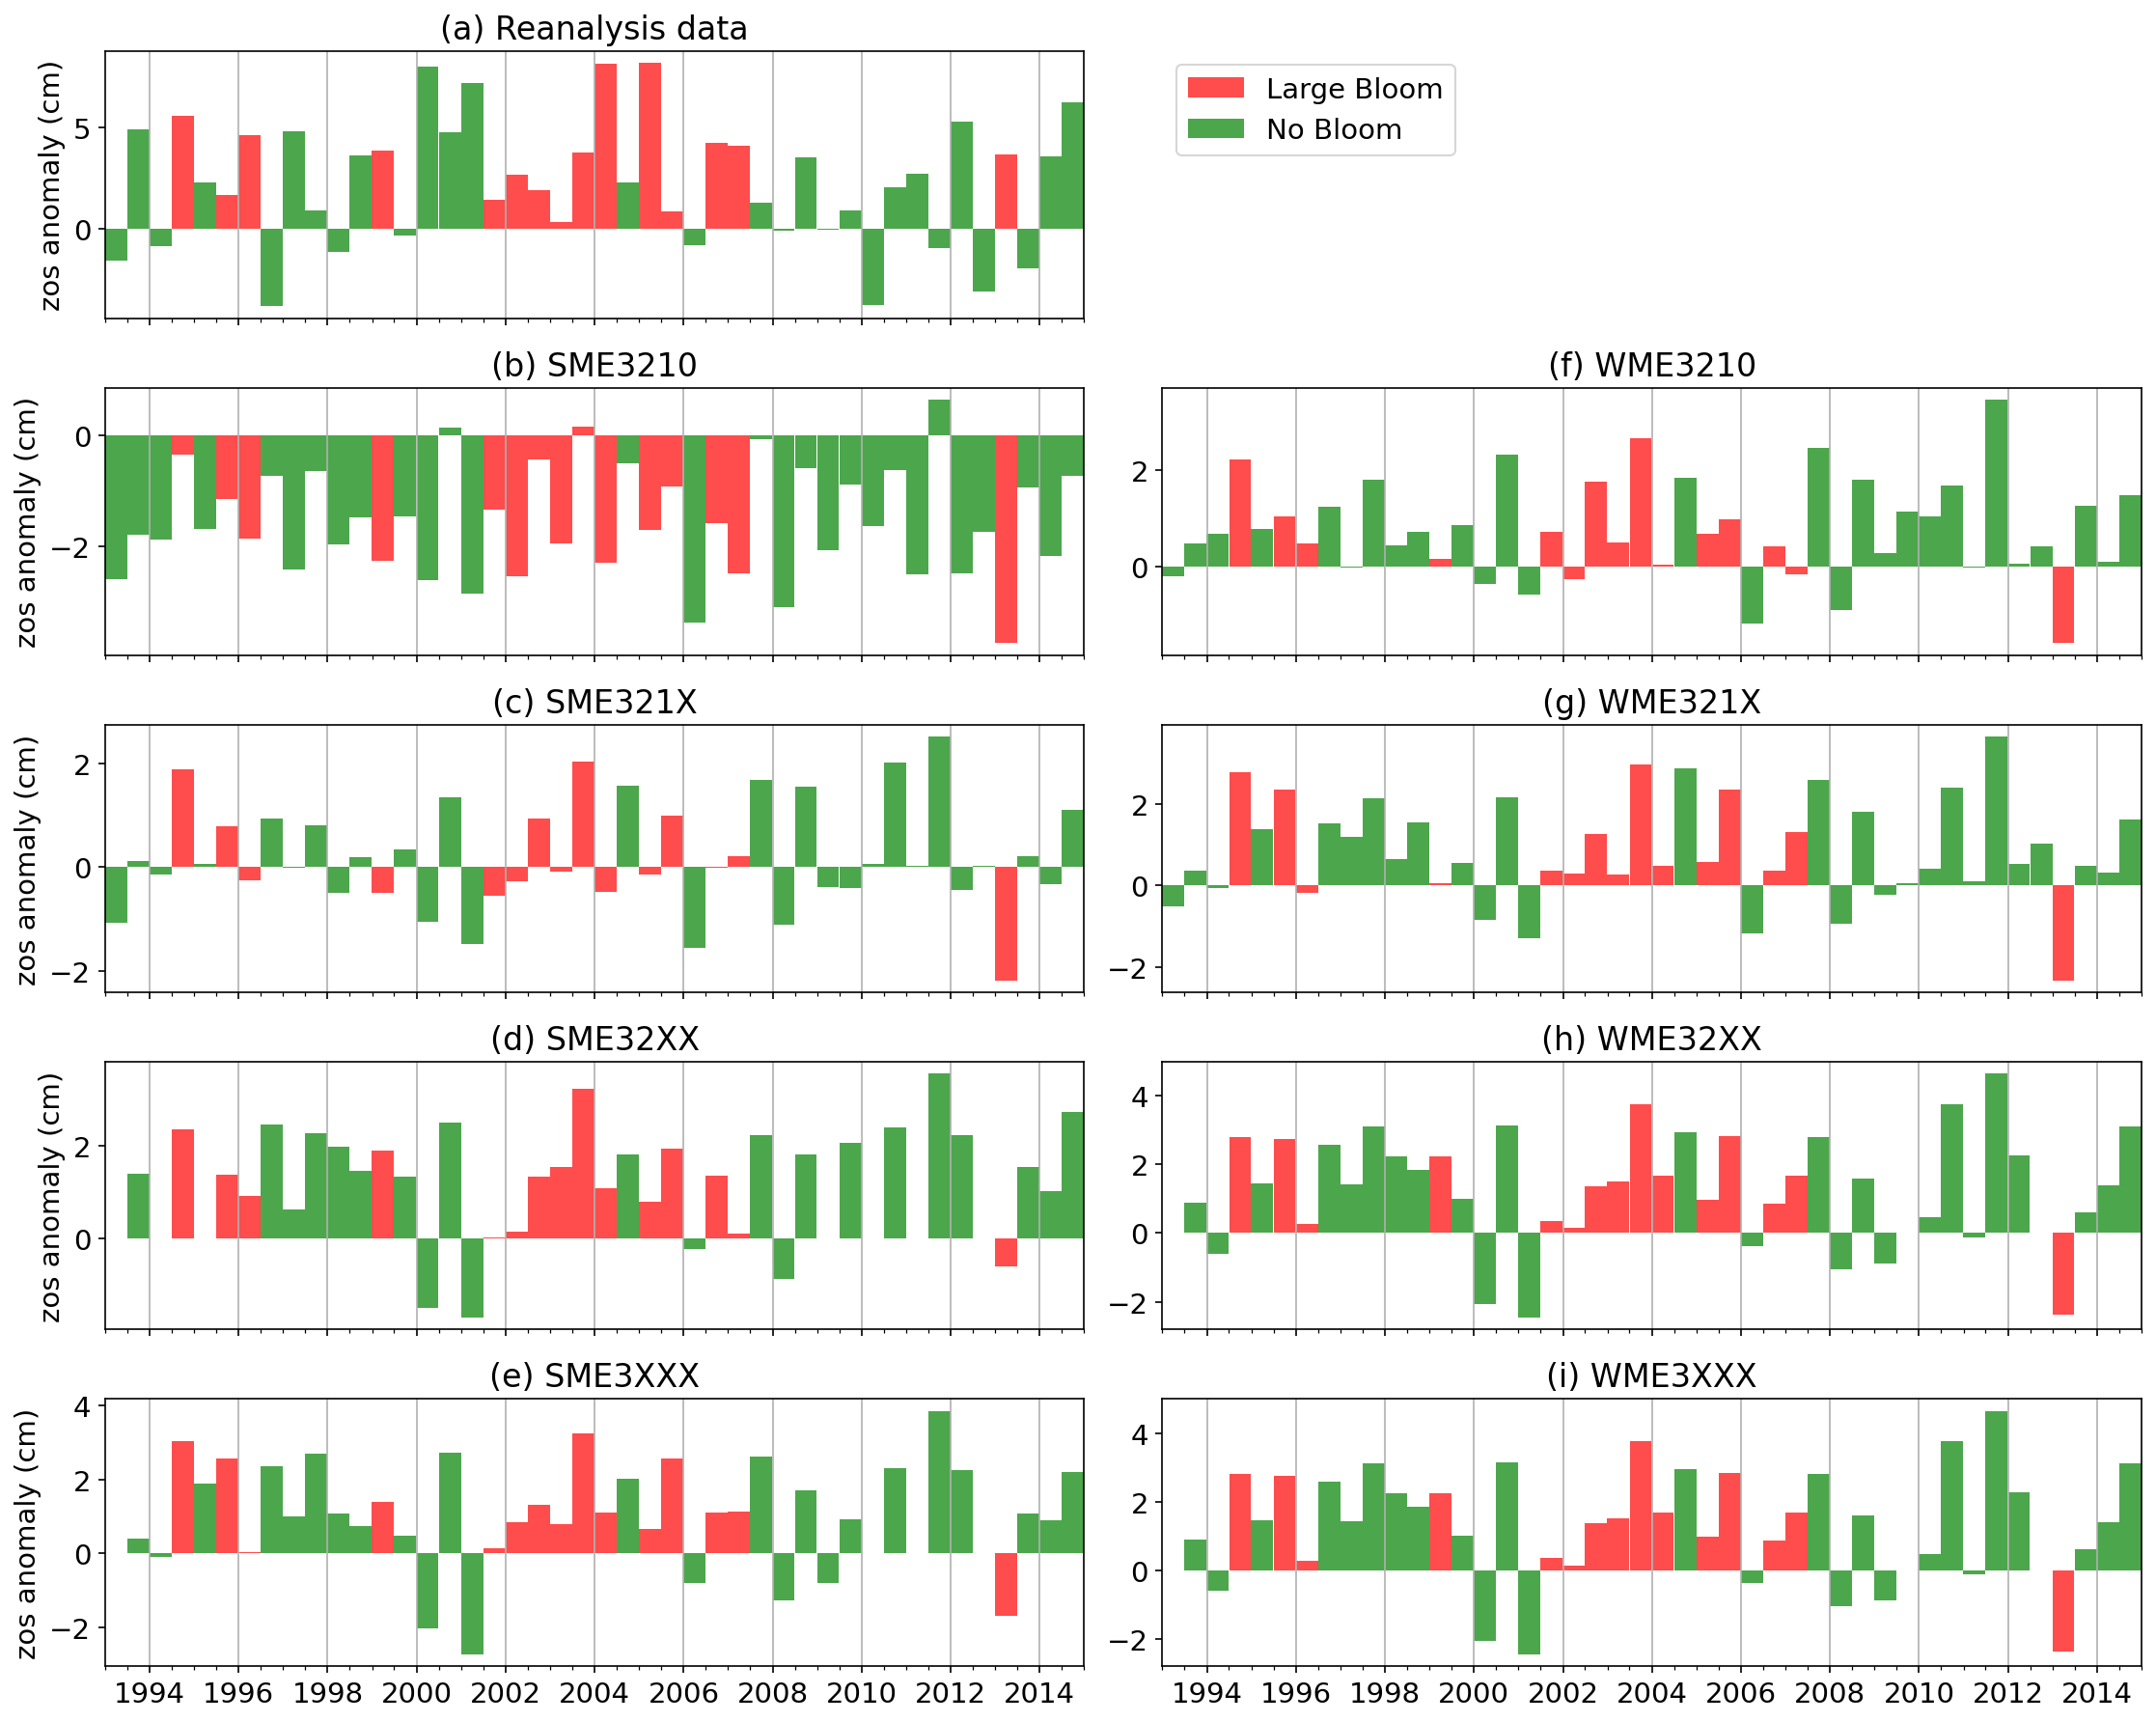

In [11]:
#[1] Create dataframe with KB,data,ESM and weight ESM data
Q=pd.date_range('1993-01-01', periods=44, freq='2Q',closed='left')
df = pd.DataFrame({'KB':reswMD.KB, \
                   'LCDM':resMD.obs, 'LCDW':resMD.obs, \
                   'LCM_3210':resMD['3210'], 'LCMW_3210':reswMD['3210'], \
                   'LCM_321X':resMD['321X'], 'LCMW_321X':reswMD['3XXX'], \
                   'LCM_32XX':resMD['32XX'], 'LCMW_32XX':reswMD['32XX'], \
                   'LCM_3XXX':resMD['3XXX'], 'LCMW_3XXX':reswMD['3XXX']},index=Q)
DL=['LCDM','LCDW','LCM_3210','LCM_321X','LCM_32XX','LCM_3XXX','LCMW_3210','LCMW_321X','LCMW_32XX','LCMW_3XXX']

#[2] Title of each subplot
tsa = ['({}) SME{}'.format(fn,nme)   for fn,nme in zip(['b','c','d','e'],NME)]
twa = ['({}) WME{}'.format(fn,nme) for fn,nme in zip(['f','g','h','i'],NME)]
tsa.insert(0,'(a) Reanalysis data')
twa.insert(0,'(x) Reanalysis data')
Title  = list(itertools.chain(*[list(x) for x in zip(tsa,twa)]))

#[3] Create axes for subplots
fig, axes = plt.subplots(5,2, figsize=(15,12), sharex=True,  dpi=150)

#[4] Plot each axes
for nax, ax in enumerate(axes.ravel()):
    
    #(1) Data with colors
    y=df.KB
    cc=['colors']*len(y)
    for n,y_i in enumerate(y):
        if y_i>0:
            cc[n]='red'
        else:
            cc[n]='green'    

    mask_N= [c == 'red' for c in cc]
    x1=df.index.copy()[mask_N]
    y1=df[DL[nax]].copy()[mask_N]

    mask_S= [c == 'green' for c in cc]
    x2=df.index.copy()[mask_S]
    y2=df[DL[nax]].copy()[mask_S]


    #(2) Plot bar chart
    BarW=181
    ax.bar(x1,y1*100,width=BarW,facecolor='red',  alpha=0.7, label='Large Bloom')
    ax.bar(x2,y2*100,width=BarW,facecolor='green', alpha=0.7, label='No Bloom')
    
    
    if nax==1:
        ax.legend(loc='upper left',fontsize=14)
        ax.bar(x1,y1*100,width=BarW,facecolor='white',  alpha=1)
        ax.bar(x2,y2*100,width=BarW,facecolor='white', alpha=1)
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_visible(False)
        continue 
    
    #(3) format the x-ticks and labels
    #years = mdates.YearLocator()   # every year
    years = mdates.YearLocator(2)   # every 5 years
    months = mdates.MonthLocator(bymonth=[1,7,13])  # every month
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    
    #(4) x-axis limit
    Start=1993
    End=2015
    start = datetime(year=Start, month=1, day=1, hour=0)
    end   = datetime(year=End, month=1, day=1, hour=0)
    ax.set_xlim(start,end)
    
    #(5) Axis labels
    if (nax % 2) == 0:
        ax.set_ylabel('zos anomaly (cm)',fontsize=14)

#     #(6) Legend
#     if (nax==0 or nax==1):
#         ax.legend(loc='best',fontsize=12)

    #(7) Grid
    ax.grid(which='major', axis='x')
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    #(8) Title
    ax.set_title(Title[nax],fontsize=16)


# [5] Save and display plot 
plt.tight_layout()
plt.savefig('res_Fig05_Data_ESMs.tif',bbox_inches='tight')
plt.show()

#### [4] Summary Figure

In [12]:
#AIC and BIC calculation 
#AIC=-(2/n)LL+2(K/2)
#BIC=-2(LL)+log(n)K
n=df.shape[0]
LLs=np.log(resm['RMSE'][1:-1].values**2)
LLw=np.log(reswm['RMSE'][1:].values**2)
print('LLs',LLs)
print('LLw',LLw)
print('K',MMES)
print('n',n)

AICs=-((2/n)*LLs)+2*(MMES/n)
AICw=-((2/n)*LLw)+2*(MMES/n)
print('AICs',AICs)
print('AICw',AICw)

BICs=-2*LLs+np.log(n)*MMES
BICw=-2*LLw+np.log(n)*MMES

LLs [3.27021132 2.62206375 2.73218331 2.6058255 ]
LLw [2.53952109 2.55630441 2.61125292 2.60038332]
K [11  9  7  4]
n 44
AICs [0.35135403 0.28990619 0.19399167 0.06337157]
AICw [0.38456722 0.29289525 0.1994885  0.06361894]


In [13]:
#[0] Select cases for both the two cases of weighting and simple average 
#Case1='3210'  #Without prior knowledge 
#Case2='321X'  #Without prescreening and subset selection 
#Case3='32XX'  #With prescreening and subset selection 
#Case4='3XXX'  #With prescreening and subset selection + parsimonious
Present=2      #[1] Each case: SME/WME  [2] Four cases: SME/WME

# x0 oscillating event frequency 
# x1 oscillating event count error 
# x2 LC position temporal match error 
# x3 LC-S temporal match error
# x4 Karenia brevis error
# x5 root-mean-square error

#[1] Dataframe for summary reults of weighted ensemble mean
#(1.1) rows
rows=['Oscillating event frequency ($x_{0}$)','Oscillating event frequency error ($x_{1}$)',
      'Temporal match error ($x_{2}$)', 'LC-S temporal match error ($x_{3}$)', 
      'Red tide bloom error ($x_{4}$)', 'Relative RMSE ($x_{5r}$)','Normaized AIC score ($x_{6,AICn}$)']

#(1.2) columns
Check='\u2713'
Cross='\u2715'
Dash='-'
SME = ['SME{}: ({}) Prior information   ({}) Prescreening-based subset selection   ({}) Optimal weighting   ({}) Parsimonious'.format(nme,pi,ps,wt,pr) \
       for nme,pi,ps,wt,pr in zip(NME,[Cross,Check,Check,Check],[Cross,Cross,Check,Check],[Cross,Cross,Cross,Cross],[Dash,Dash,Dash,Dash])]
WME = ['WME{}: ({}) Prior information   ({}) Prescreening-based subset selection   ({}) Optimal weighting   ({}) Parsimonious'.format(nme,pi,ps,wt,pr) \
       for nme,pi,ps,wt,pr in zip(NME,[Cross,Check,Check,Check],[Cross,Cross,Check,Check],[Check,Check,Check,Check],[Cross,Cross,Cross,Check])]
if Present==1:
    columns  = list(itertools.chain(*[list(x) for x in zip(SME,WME)]))
elif Present==2:
    columns=[*SME,*WME]
columns.insert(0,'Reanalysis data')

#(1.3) Create dataframe
SF = pd.DataFrame(columns = columns,index=rows)

#[2] Process results

#(2.1) Diagnostics
MAX_RMSE=resm.loc['3210','RMSE']
print('MAX_RMSE',MAX_RMSE)

def DIG(nn,res,Case,MAX_RMSE):
        
    #Frequency of an event (x0/x1) 
    FData=resm.loc['obs','LCS']/(resm.loc['obs','LCN']+resm.loc['obs','LCS'])
    FModel=res.loc[Case,'LCS']/(res.loc[Case,'LCN']+res.loc[Case,'LCS'])

    #x0, x1
    SF.iloc[0,nn+1]=FModel
    SF.iloc[1,nn+1]=abs(FData-FModel)
    
    #Temporal match error (x2) 
    SF.iloc[2,nn+1]=res.loc[Case,'Err_Tot']
    
    #LSC_S temporal match error (x3) 
    SF.iloc[3,nn+1]=res.loc[Case,'Err_LCS']
    
    #Karenia brevis error (x4) 
    SF.iloc[4,nn+1]=res.loc[Case,'Err_KB']
    
    #RMSE(x5)
    SF.iloc[5,nn+1]=res.loc[Case,'RMSE']/MAX_RMSE
    
    return SF

#(2.2) Reanalysis data
SF=DIG(-1,resm,'obs',MAX_RMSE)

#(2.3) Ensmble model data
if Present==1:
    EL=['3210','3210','321X','321X','32XX','32XX','3XXX','3XXX']
    for nn,Case in enumerate(EL):
        if (nn % 2) == 0:  #SME (even)
            SF=DIG(nn,resm,Case,MAX_RMSE)
        else:
            SF=DIG(nn,reswm,Case,MAX_RMSE)         
elif Present==2:
    EL=['3210','321X','32XX','3XXX','3210','321X','32XX','3XXX']
    for nn,Case in enumerate(EL):
        if nn<4:
            SF=DIG(nn,resm,Case,MAX_RMSE)
        else:
            SF=DIG(nn,reswm,Case,MAX_RMSE)
#(2.4) AIC
SF.iloc[6,1:5]=AICs
SF.iloc[6,5:]=AICw

#(2.5) Display data
display(SF)

MAX_RMSE 5.13


,Reanalysis data,SME3210: (✕) Prior information (✕) Prescreening-based subset selection (✕) Optimal weighting (-) Parsimonious,SME321X: (✓) Prior information (✕) Prescreening-based subset selection (✕) Optimal weighting (-) Parsimonious,SME32XX: (✓) Prior information (✓) Prescreening-based subset selection (✕) Optimal weighting (-) Parsimonious,SME3XXX: (✓) Prior information (✓) Prescreening-based subset selection (✕) Optimal weighting (-) Parsimonious,WME3210: (✕) Prior information (✕) Prescreening-based subset selection (✓) Optimal weighting (✕) Parsimonious,WME321X: (✓) Prior information (✕) Prescreening-based subset selection (✓) Optimal weighting (✕) Parsimonious,WME32XX: (✓) Prior information (✓) Prescreening-based subset selection (✓) Optimal weighting (✕) Parsimonious,WME3XXX: (✓) Prior information (✓) Prescreening-based subset selection (✓) Optimal weighting (✓) Parsimonious
Oscillating event frequency ($x_{0}$),0.272727,0.931818,0.227273,0.477273,0.204545,0.227273,0.227273,0.227273,0.227273
Oscillating event frequency error ($x_{1}$),0,0.659091,0.0454545,0.204545,0.0681818,0.0454545,0.0454545,0.0454545,0.0454545
Temporal match error ($x_{2}$),0,0.705,0.364,0.477,0.25,0.181818,0.181818,0.181818,0.227273
LC-S temporal match error ($x_{3}$),0,0.083,0.75,0.5,0.583,0.416667,0.416667,0.416667,0.5
Red tide bloom error ($x_{4}$),0,0.933,0.2,0.6,0.133,0.0666667,0.0666667,0.0666667,0.0666667
Relative RMSE ($x_{5r}$),0,1,0.723197,0.764133,0.717349,0.693957,0.699805,0.719298,0.7154
"Normaized AIC score ($x_{6,AICn}$)",NaN,0.351354,0.289906,0.193992,0.0633716,0.384567,0.292895,0.199489,0.0636189


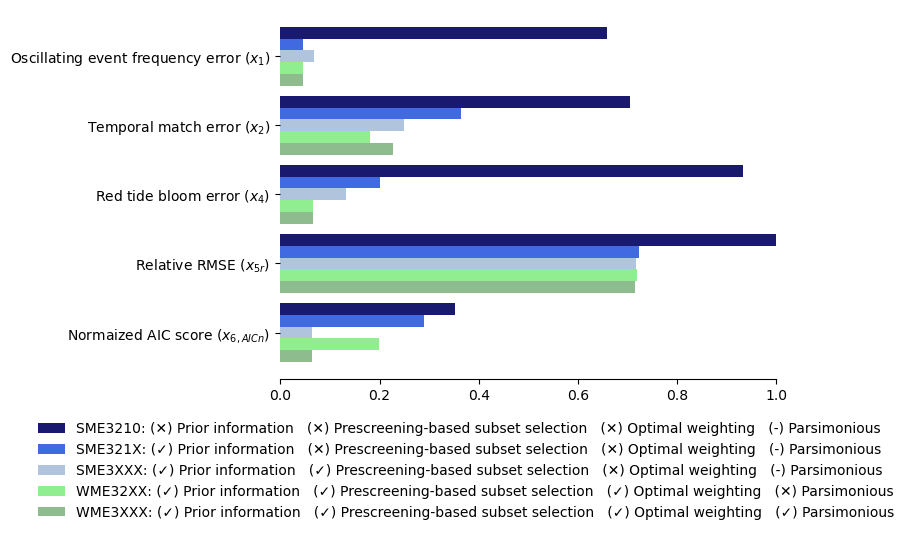

In [14]:
#[3] Select predictors and ensemble to plot
IDX=[0,1,2,4,7,8] #Select ensembles [0] Reanalysis data, [1] SME3210, ..., [8] WME3XXX
IDX=IDX[1:]
METRIC=[1,2,4,5,6]
data=SF.iloc[METRIC,IDX]

#[4] Plot summary results
#(4.1) Create figure and subplots
fig, ax = plt.subplots(1,1)

#(4.2) Choose bar colors
colors=['crimson','midnightblue','royalblue','deepskyblue','lightsteelblue','seagreen','mediumseagreen','lightgreen','darkseagreen']
#colors=['crimson','lightsteelblue','deepskyblue','royalblue','midnightblue','darkseagreen','lightgreen','mediumseagreen','seagreen']
colors = [colors[i] for i in IDX]

#(4.3) Plot horizontal bar chart top to bottom
data.plot.barh(ax=ax, width=0.85,color=colors)
plt.gca().invert_yaxis()

#(4.4) Remove all the ticks and label xticks
#plt.tick_params(labelbottom='on')
#plt.xticks([0,1], ['0', '1'])
ax.tick_params(axis="x",direction='out')

#(4.5) Set axis lim
plt.xlim(0, 1)

#(4.6) Remove plot frame
for n,spine in enumerate(plt.gca().spines.values()):
    if n==0:
        spine.set_visible(False)
    elif n==1:    
        spine.set_visible(False)
    elif n==3:
        spine.set_visible(False)

#(4.7) Legend outside
ax.legend(bbox_to_anchor=(1.25,-0.1), borderaxespad=0.,frameon=False)    #Left/Right , Up/down

#(4.8) Save and show plot
plt.savefig('res_Fig06_Summary.tif',bbox_inches='tight')
plt.show()